In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from collections import Counter, OrderedDict
import sys

from utils import nice_tree_plot, niceprint, permute_square, invert_permutation, without_diag
from compute_pam import compute_combo_tensor_pam, IndividualNodeAlphaCalc
from example_graphs import make_tree
from sim_data import PAMSampler, topics_griffiths_steyvers, ensure_anchor_words
from lda_collapsed_gibbs import CollapsedGibbs
from tree_extraction import Aho
from tree_extraction.Aho import get_ratio_matrix
from alpha_extract import AlphaExtract
from param_stats import topic_difference, find_flat_permutation, find_structural_permutation

from end_to_end import Analysis

In [2]:
np.random.seed(1)

## Outline

1. Set up parameters of the model (tree structure, alphas, and topic definitions -- anything else?)
2. Compute "true" co-occurrence matrix
3. Generate some simulated data by sampling from the model
  - Parameters: Number of documents, distribution over document sizes
4. Compute "empirical" co-occurrence matrix (using known per-word-slot topic assignments).  Compare to "true" co-occurrence matrix.
5. Apply LDA or anchor words to the simulated data -- estimate topics and co-occurrence matrix.  Compare "estimated" co-occurrence matrix to "true" and "empirical" matrices.  Compare "estimated" topics to "true" topics.
  - Parameters: number of topics; any other parameters needed for the chosen topic-estimation algorithm
6. Compute ratio matrix
7. Derive triplet constraints from ratio matrix
8. Apply Aho's algorithm to constraints, producing a tree where each leaf corresponds to a topic.  Compare to "true" tree structure.
9. Extract alpha parameters from co-occurrence matrix.  Compare to "true" alpha parameters.
  - Parameters: $\alpha_{max}$ and $\delta_{min}$ corresponding to hypothesis class
  
TODO: Find a way to remove # of topics as a parameter (eg, measure perplexity, and loop over different of # topics)

In [3]:
branching_factors = [2, 2, 2]
num_true_topics = np.prod(branching_factors)  # number of topics with which to generate data

true_tree = make_tree(branching_factors)
index_to_leaf = [x for x in true_tree.nodes() if true_tree.out_degree(x) == 0]
leaf_to_index = {leaf: idx for idx, leaf in enumerate(index_to_leaf)}

In [4]:
# N = 10  # number of documents to generate
# M = 20  # number of words per document
# V = 25  # number of words in vocabulary
# dim = 5  # size of "square" to use in defining topics
# assert dim ** 2 == V

In [5]:
# N = 1000  # number of documents to generate
# M = 200  # number of words per document
# V = 100  # number of words in vocabulary
# dim = 10  # size of "square" to use in defining topics
# assert dim ** 2 == V

In [6]:
N = 10000  # number of documents to generate
M = 500  # number of words per document
V = 100  # number of words in vocabulary
dim = 10  # size of "square" to use in defining topics
assert dim ** 2 == V

In [7]:
true_topics = topics_griffiths_steyvers(num_topics = num_true_topics, dimension = dim)

# true_topics = ensure_anchor_words(true_topics)

In [8]:
true_alphas = {
    1: 1.0,                           2: 1.0,
    3: 1.0,         4: 1.0,           5: 1.0,           6: 1.0,
    7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0,
}

In [9]:
# Main user-selected parameters for training & extraction
num_topics_to_train = num_true_topics
delta_min = 0.1
alpha_max = 10.0
custom_prior = 1.3 ** np.arange(len(index_to_leaf))[::-1]

In [10]:
# topic_extraction_strategy = "CollapsedGibbs"
# topic_extraction_params = dict(alpha = custom_prior)

In [11]:
topic_extraction_strategy = "AnchorWords"
topic_extraction_params = dict(
    anchor_thresh = 0,
    new_dim = 50,
)

In [12]:
a = Analysis(
    # Data generation params:
    true_tree = true_tree,
    true_alphas = true_alphas,
    num_docs = N,
    words_per_doc = M,
    vocab_size = V,
    true_topics = true_topics,
    leaf_to_index = leaf_to_index,
    # Extraction params:
    num_topics_to_train = num_topics_to_train,
    delta_min = delta_min,
    alpha_max = alpha_max,
    topic_extraction_strategy = topic_extraction_strategy,
    topic_extraction_params = topic_extraction_params,
)

In [13]:
a.run();

100%|██████████| 10000/10000 [11:09<00:00, 14.93it/s]


Input matrix shape: (100, 10000)
identifying candidate anchors
100 candidates
Sum of entries in Q is  0.9999999999999885
Multiplying Q took  0.4426240921020508 seconds
Q sum is 0.9999999999999885
done reading documents
anchors are:
0 w81
1 w62
2 w70
3 w73
4 w36
5 w18
6 w07
7 w27
begin threaded recovery with 8 processors
0	25	0.5041288826424972
done recovering
w81 : w81 w51 w41 w91 w71 w61 w31 w01 w21 w11 
w62 : w62 w72 w52 w42 w82 w92 w22 w12 w32 w02 
w70 : w70 w60 w40 w80 w50 w90 w20 w30 w10 w00 
w73 : w73 w83 w43 w53 w63 w93 w03 w23 w13 w33 
w36 : w36 w35 w39 w37 w34 w38 w33 w32 w31 w30 
w18 : w18 w15 w17 w16 w14 w19 w11 w13 w10 w12 
w07 : w07 w08 w04 w09 w05 w06 w00 w02 w01 w03 
w27 : w27 w29 w25 w28 w26 w24 w21 w23 w20 w22 


## Display results

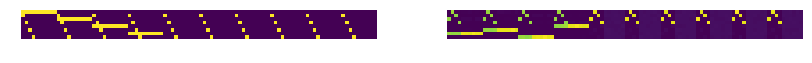

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(a.true_topics)
ax[0].axis('off')
ax[1].imshow(a.est_topics)
ax[1].axis('off')
None

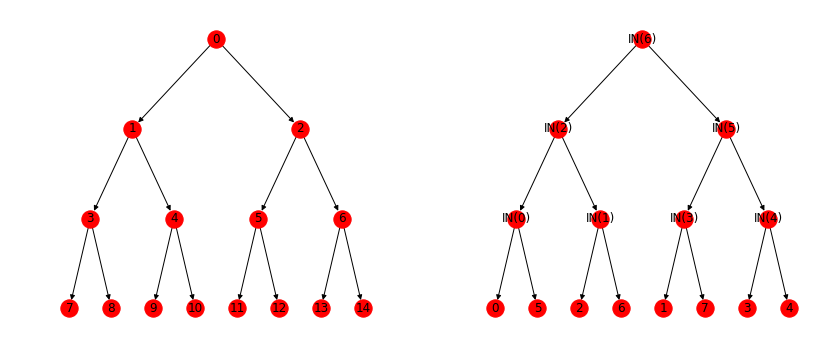

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
nice_tree_plot(a.true_tree, ax[0])
nice_tree_plot(a.est_tree, ax[1])

In [16]:
print(a.true_alphas)
print(a.est_alphas)

{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}
{IN(2): 3.2465111177877697, IN(0): 2.3223503401784082, 0: 0.8053360483813412, 5: 0.8128188241791513, IN(1): 2.2788914931084348, 2: 0.8539534434034752, 6: 0.829465246109366, IN(5): 3.1916423840459793, IN(3): 1.714497885473692, 1: 0.796887660518036, 7: 0.8181992586806206, IN(4): 1.68521760042169, 3: 0.8434436996856501, 4: 0.8414760830745638}


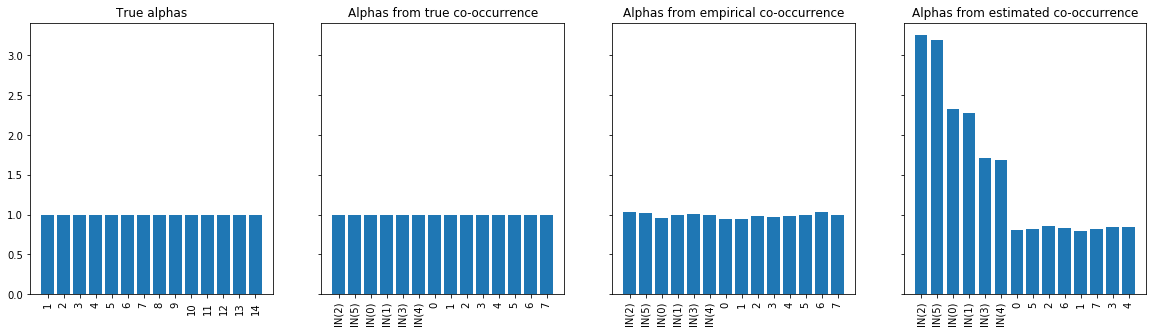

In [17]:
specs = [
    dict(name="True alphas", tree=a.true_tree, alphas=a.true_alphas),
    dict(name="Alphas from true co-occurrence", tree=a.true_c_tree, alphas=a.true_c_alphas),
    dict(name="Alphas from empirical co-occurrence", tree=a.emp_tree, alphas=a.emp_alphas),
    dict(name="Alphas from estimated co-occurrence", tree=a.est_tree, alphas=a.est_alphas),
]
fig, ax = plt.subplots(1, len(specs), figsize=(5*len(specs), 5), sharey=True)
for i, spec in enumerate(specs):
    labels = []
    y = []
    for _, successors in nx.bfs_successors(spec["tree"], source=spec["tree"].graph["root"]):
        for node in successors:
            labels.append(str(node))
            y.append(spec["alphas"][node])
    x = np.arange(len(y))
    ax[i].bar(x, y)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_title(spec["name"])

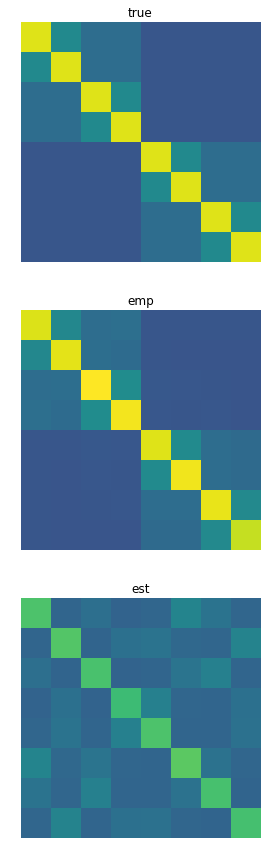

In [18]:
# Plot cooccurrence matrices
specs = [
    dict(name='true', cooccur=a.true_cooccur),
    dict(name='emp', cooccur=a.emp_cooccur),
    dict(name='est', cooccur=a.est_cooccur),
]

vmin=0.0
vmax=np.max([np.max(s["cooccur"]) for s in specs])

fig, ax = plt.subplots(len(specs), 1, figsize=(5, 5*len(specs)))
for i, spec in enumerate(specs):
    ax[i].imshow(spec["cooccur"], vmin=vmin, vmax=vmax)
    ax[i].axis('off')
    ax[i].set_title(spec["name"])

## Save results

In [19]:
a.save('results/results.pkl')

Saving to results/results_2019-05-15_at_23-57-55.pkl


## Find permutation that maps estimated topics to true topics

In [20]:
perm = find_flat_permutation(true_topics=a.true_topics, est_topics=a.est_topics)
perm

array([6, 2, 5, 0, 7, 1, 4, 3])

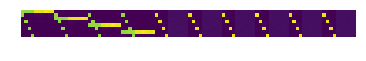

In [21]:
fig, ax = plt.subplots()
ax.imshow(a.est_topics[perm, :])
ax.axis('off')
None

In [22]:
est_cooccur_permuted = permute_square(X = a.est_cooccur, perm = perm)

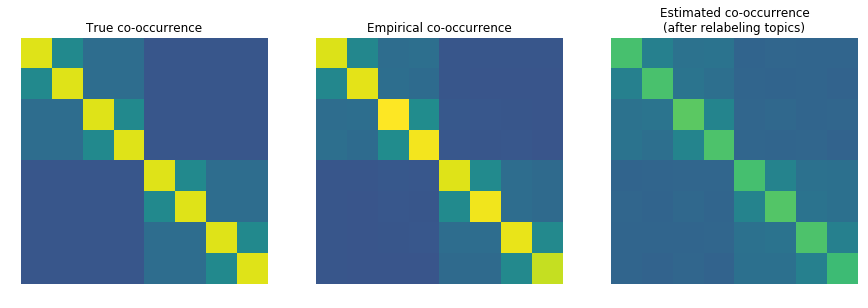

In [23]:
# Plot cooccurrence matrices
specs = [
    dict(name='True co-occurrence', cooccur=a.true_cooccur),
    dict(name='Empirical co-occurrence', cooccur=a.emp_cooccur),
    dict(name='Estimated co-occurrence\n(after relabeling topics)', cooccur=est_cooccur_permuted), 
]

vmin=0.0
vmax=np.max([np.max(s["cooccur"]) for s in specs])

fig, ax = plt.subplots(1, len(specs), figsize=(5*len(specs), 5))
for i, spec in enumerate(specs):
    ax[i].imshow(spec["cooccur"], vmin=vmin, vmax=vmax)
    ax[i].axis('off')
    ax[i].set_title(spec["name"])

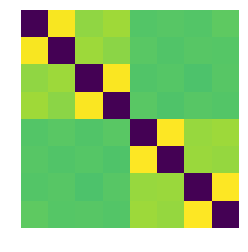

In [24]:
est_ratio_permuted = get_ratio_matrix(est_cooccur_permuted)

fig, ax = plt.subplots()
ax.imshow(without_diag(est_ratio_permuted))
ax.axis('off')
None

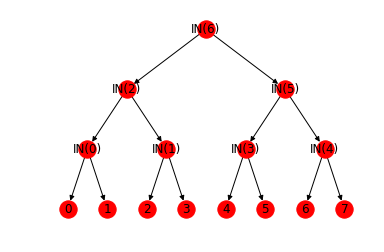

In [25]:
est_tree_permuted = Aho.extract(est_ratio_permuted, apply_ratio=False)
nice_tree_plot(est_tree_permuted)

In [26]:
constraints_from_est_tree_permuted = Aho.constraints_from_tree(est_tree_permuted)

In [27]:
constraints_from_true_tree = Aho.constraints_from_tree(true_tree)
constraints_from_true_tree = \
    [Aho.TripletConstraint(leaf_to_index[i], leaf_to_index[j], leaf_to_index[k], s)
    for i,j,k,s in constraints_from_true_tree]

In [28]:
len(constraints_from_est_tree_permuted), len(constraints_from_true_tree)

(104, 104)

In [29]:
constraints_match = constraints_from_est_tree_permuted == constraints_from_true_tree
print("Constraints match: {}".format(constraints_match))
if not constraints_match:
    print("=========================\nWARNING: Found mismatch")

Constraints match: True


## Compare results of alpha extraction

0.003800853866374224


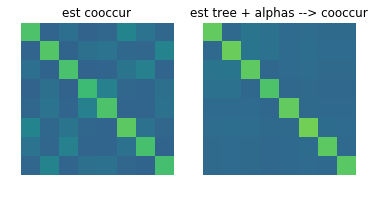

In [30]:
zzz = compute_combo_tensor_pam(a.est_tree, alpha=a.est_alphas)

print(np.max(np.abs(zzz - a.est_cooccur)))

fig, ax = plt.subplots(1, 2)

ax[0].imshow(a.est_cooccur, vmin=vmin, vmax=vmax)
ax[0].axis('off')
ax[0].set_title('est cooccur')

ax[1].imshow(zzz, vmin=vmin, vmax=vmax)
ax[1].axis('off')
ax[1].set_title('est tree + alphas --> cooccur')

None

0.0004953869686088914

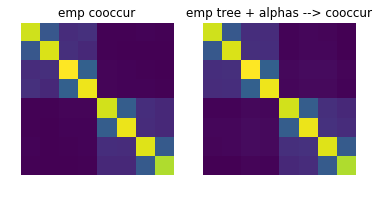

In [31]:
zzz = compute_combo_tensor_pam(a.emp_tree, alpha=a.emp_alphas)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(a.emp_cooccur)
ax[0].axis('off')
ax[0].set_title('emp cooccur')

ax[1].imshow(zzz)
ax[1].axis('off')
ax[1].set_title('emp tree + alphas --> cooccur')

np.max(np.abs(zzz - a.emp_cooccur))

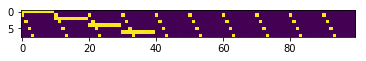

In [32]:
# Empirical estimate of topics
plt.imshow(a.emp_topics);

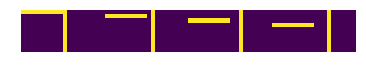

In [33]:
reshaped = np.hstack([x.reshape((dim, dim)) for x in a.true_topics])
fig, ax = plt.subplots()
ax.imshow(reshaped)
ax.axis('off')
None

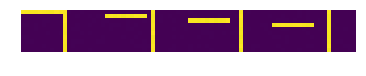

In [34]:
reshaped = np.hstack([x.reshape((dim, dim)) for x in a.emp_topics])
fig, ax = plt.subplots()
ax.imshow(reshaped)
ax.axis('off')
None

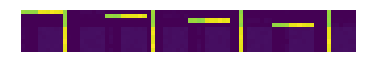

In [35]:
reshaped = np.hstack([x.reshape((dim, dim)) for x in a.est_topics[perm, :]])
fig, ax = plt.subplots()
ax.imshow(reshaped)
ax.axis('off')
None

## Sanity-checking alpha-extraction algorithm

{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}
0.0


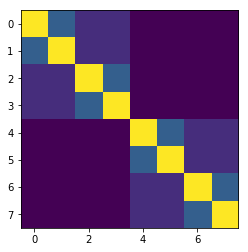

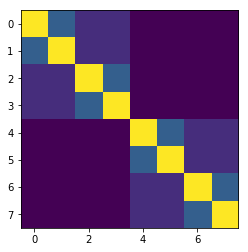

In [36]:
alphas_from_true_cooccur = AlphaExtract(a.true_tree, a.true_cooccur).extract()
print(alphas_from_true_cooccur)
meta_true_cooccur = compute_combo_tensor_pam(a.true_tree, alpha = alphas_from_true_cooccur)
plt.figure()
plt.imshow(meta_true_cooccur);
plt.figure()
plt.imshow(a.true_cooccur);

print(np.max(np.abs(a.true_cooccur - meta_true_cooccur)))

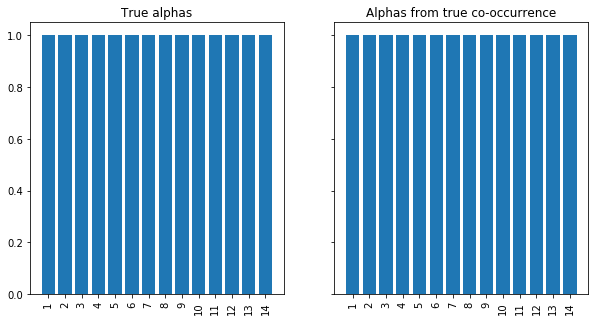

In [37]:
specs = [
    dict(name="True alphas", tree=a.true_tree, alphas=a.true_alphas),
    dict(name="Alphas from true co-occurrence", tree=a.true_tree, alphas=alphas_from_true_cooccur),
]
fig, ax = plt.subplots(1, len(specs), figsize=(5*len(specs), 5), sharey=True)
alpha_vectors = dict()
for i, spec in enumerate(specs):
    labels = []
    y = []
    for _, successors in nx.bfs_successors(spec["tree"], source=spec["tree"].graph["root"]):
        for node in successors:
            labels.append(str(node))
            y.append(spec["alphas"][node])
    x = np.arange(len(y))
    ax[i].bar(x, y)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_title(spec["name"])
    alpha_vectors[spec["name"]] = np.array(y)

In [38]:
np.max(np.abs(alpha_vectors["True alphas"] - alpha_vectors["Alphas from true co-occurrence"]))

0.0

## Result comparisons

In [39]:
# import end_to_end
# import importlib
# importlib.reload(end_to_end)
# del end_to_end
# from end_to_end import Analysis

In [40]:
save_figures_directory = "../extract-tree-writeup/figures"
# save_figures_directory = None  # Use `None` to skip saving

ALL
  ----------------------------------------
  True co-occurrence vs Empirical co-occurrence vs Estimated co-occurrence
  ----------------------------------------
  Saved figure to ../extract-tree-writeup/figures/True-vs-Empirical-vs-Estimated-cooccur.pdf


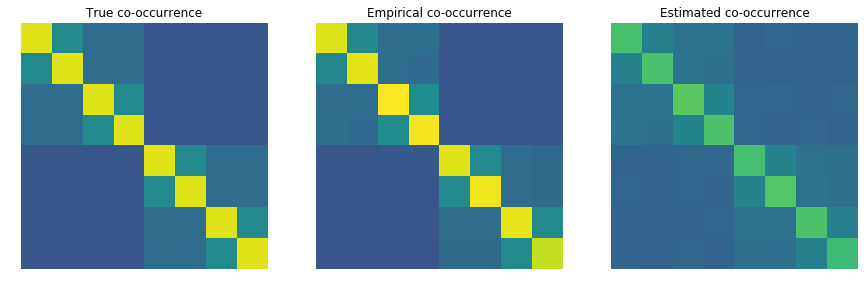

  Max abs discrepancy Empirical co-occurrence vs True co-occurrence: 0.00183
  Max rel discrepancy Empirical co-occurrence vs True co-occurrence: 0.0493
  Max abs discrepancy Estimated co-occurrence vs True co-occurrence: 0.0104
  Max rel discrepancy Estimated co-occurrence vs True co-occurrence: 0.282
  ----------------------------------------
  True ratio matrix vs Empirical ratio matrix vs Estimated ratio matrix
  ----------------------------------------
  Saved figure to ../extract-tree-writeup/figures/True-vs-Empirical-vs-Estimated-ratio_matrix.pdf


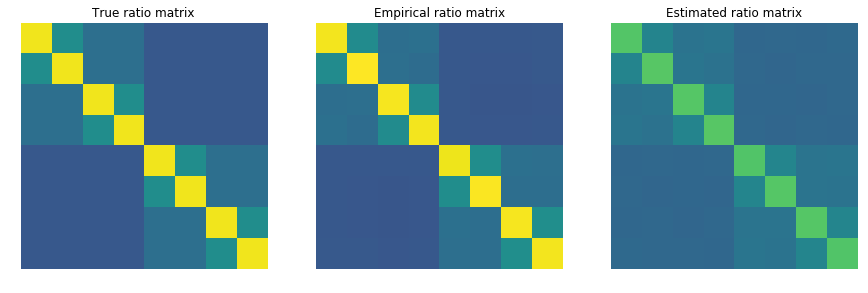

  Max abs discrepancy Empirical ratio matrix vs True ratio matrix: 0.0558
  Max rel discrepancy Empirical ratio matrix vs True ratio matrix: 0.0304
  Max abs discrepancy Estimated ratio matrix vs True ratio matrix: 0.604
  Max rel discrepancy Estimated ratio matrix vs True ratio matrix: 0.255
  ----------------------------------------
  True topics vs Empirical topics vs Estimated topics
  ----------------------------------------
  Saved figure to ../extract-tree-writeup/figures/True-vs-Empirical-vs-Estimated-topics.pdf


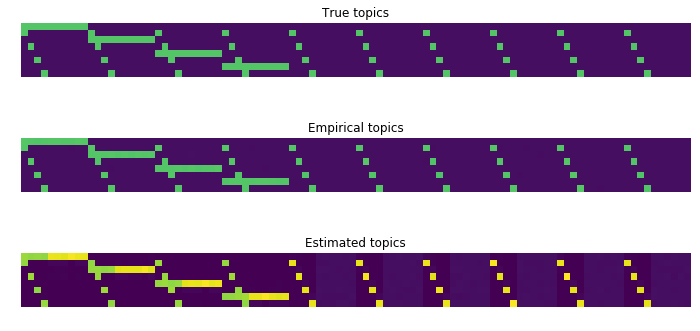

  Max abs discrepancy Empirical topics vs True topics: 0.000811
  Max rel discrepancy Empirical topics vs True topics: 0.0658
  Max abs discrepancy Estimated topics vs True topics: 0.025
  Max rel discrepancy Estimated topics vs True topics: 1
  ----------------------------------------
  True constraints vs Empirical constraints vs Estimated constraints
  ----------------------------------------
  Max discrepancy: 0.256
  ----------------------------------------
  True tree vs Empirical tree vs Estimated tree
  ----------------------------------------
  Saved figure to ../extract-tree-writeup/figures/True-vs-Empirical-vs-Estimated-tree.pdf


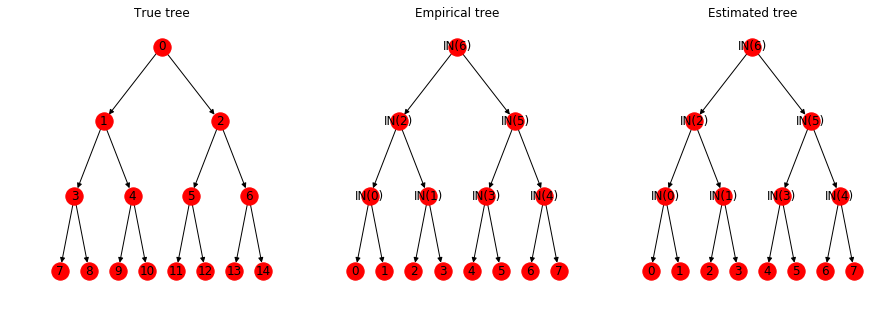

  ----------------------------------------
  True alphas vs Empirical alphas vs Estimated alphas
  ----------------------------------------
  Saved figure to ../extract-tree-writeup/figures/True-vs-Empirical-vs-Estimated-alphas.pdf


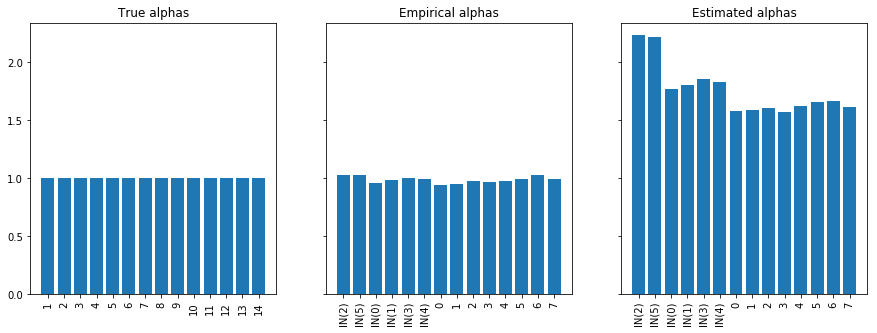

In [42]:
def show_matrix_diff(matrix_name, matrix_key, specs, horizontal = True, width_height = None):
    assert len(specs) > 1
    
    print("  " + "-"*40)
    print("  " + " vs ".join("{} {}".format(s["name"], matrix_name) for s in specs))
    print("  " + "-"*40)
    
    vmin=0.0
    vmax=np.max([np.max(s["results"][matrix_key]) for s in specs])

    if width_height is None:
        width_height = np.array([5.0, 5.0])
    
    dims = np.array([1, len(specs)])
    if not horizontal:
        dims = dims[::-1]
    
    fig, ax = plt.subplots(*dims, figsize = dims[::-1] * np.array(width_height, dtype='float'))
    for i, spec in enumerate(specs):
        ax[i].imshow(spec["results"][matrix_key], vmin=vmin, vmax=vmax)
        ax[i].axis('off')
        ax[i].set_title("{} {}".format(spec["name"], matrix_name))
    if save_figures_directory:
        versus_string = "-vs-".join(s["name"] for s in specs)
        filename = save_figures_directory + "/{}-{}.pdf".format(versus_string, matrix_key)
        plt.savefig(filename)
        print("  Saved figure to {}".format(filename))
    plt.show()
        
    for spec_index, spec in enumerate(specs):
        if spec_index > 0:
            a, b = specs[0]["results"][matrix_key], specs[spec_index]["results"][matrix_key]
            msg = "{} {} vs {} {}".format(specs[spec_index]["name"], matrix_name, specs[0]["name"], matrix_name)
            abs_discrep = np.max(np.abs(a - b))
            if np.min(np.abs(a)) == 0.0:
                rel_discrep = np.inf
            else:
                rel_discrep = np.max(np.abs((a - b) / a))
            print("  Max abs discrepancy {}: {:.3g}".format(msg, abs_discrep))
            print("  Max rel discrepancy {}: {:.3g}".format(msg, rel_discrep))

def show_constraints_diff(specs):
    assert len(specs) > 1
    print("  " + "-"*40)
    print("  " + " vs ".join("{} constraints".format(s["name"]) for s in specs))
    print("  " + "-"*40)
    sorted_constraints = [sorted(s["results"]["constraints"]) for s in specs]
    discrepancies = []
    for constraint_index in range(max(len(x) for x in sorted_constraints)):
        comparable = True
        for spec_index in range(len(specs)):
            if constraint_index >= len(sorted_constraints[spec_index]):
                comparable = False
                print("  Longer than list {}".format(spec_index))
                break
        if not comparable:
            continue
        for spec_index in range(1, len(specs)):
            for attr in ["i", "j", "k"]:
                x0 = getattr(sorted_constraints[0][constraint_index], attr)
                x1 = getattr(sorted_constraints[spec_index][constraint_index], attr)
                if x0 != x1:
                    comparable = False
                    print("  Mismatch at constraint index {}, spec index {} (vs 0), attr {}".format(constraint_index, spec_index, attr))
                    break
            if not comparable:
                continue
            else:
                y0 = sorted_constraints[0][constraint_index].strength
                y1 = sorted_constraints[spec_index][constraint_index].strength
                discrepancies.append(y1 - y0)
    if len(discrepancies) == 0:
        print("  All mismatched")
    else:
        print("  Max discrepancy: {:.3g}".format(np.max(np.abs(discrepancies))))

def show_tree_diff(specs):
    print("  " + "-"*40)
    print("  " + " vs ".join("{} tree".format(s["name"]) for s in specs))
    print("  " + "-"*40)
    fig, ax = plt.subplots(1, len(specs), figsize=(5*len(specs), 5))
    for i, spec in enumerate(specs):
        nice_tree_plot(spec["results"]["tree"], ax=ax[i])
        ax[i].set_title("{} tree".format(spec["name"]))
    if save_figures_directory:
        versus_string = "-vs-".join(s["name"] for s in specs)
        filename = save_figures_directory + "/{}-tree.pdf".format(versus_string)
        plt.savefig(filename)
        print("  Saved figure to {}".format(filename))
    plt.show()

def show_alphas_diff(specs):
    print("  " + "-"*40)
    print("  " + " vs ".join("{} alphas".format(s["name"]) for s in specs))
    print("  " + "-"*40)
    fig, ax = plt.subplots(1, len(specs), figsize=(5*len(specs), 5), sharey=True)
    for i, spec in enumerate(specs):
        labels = []
        y = []
        for _, successors in nx.bfs_successors(spec["results"]["tree"], source=spec["results"]["tree"].graph["root"]):
            for node in successors:
                labels.append(str(node))
                y.append(spec["results"]["alphas"][node])
        x = np.arange(len(y))
        ax[i].bar(x, y)
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(labels, rotation=90)
        ax[i].set_title("{} alphas".format(spec["name"]))
    if save_figures_directory:
        versus_string = "-vs-".join(s["name"] for s in specs)
        filename = save_figures_directory + "/{}-alphas.pdf".format(versus_string)
        plt.savefig(filename)
        print("  Saved figure to {}".format(filename))
    plt.show()

specs = [
    dict(name="True", results=a.true_results),
    #dict(name="True", results=a.true_c_results),
    dict(name="Empirical", results=a.emp_results),
    #dict(name="Estimated", results=a.est_results),
    dict(name="Estimated", results=a.est_results_permuted),
]

print("="*40)
print("ALL")
print("="*40)
show_matrix_diff(matrix_name = "co-occurrence", matrix_key = "cooccur", specs = specs)
show_matrix_diff(matrix_name = "ratio matrix", matrix_key = "ratio_matrix", specs = specs)
show_matrix_diff(matrix_name = "topics", matrix_key = "topics", specs = specs, horizontal = False, width_height = [12, 2])
show_constraints_diff(specs = specs)
show_tree_diff(specs = specs)
show_alphas_diff(specs = specs)

# pairs = [
#     (specs[0], specs[1]),
#     (specs[1], specs[2]),
#     (specs[0], specs[2]),
# ]

# for p1, p2 in pairs:
#     print("="*40)
#     print("{} vs {}".format(p1["name"], p2["name"]))
#     print("="*40)
#     show_matrix_diff(matrix_name = "co-occurrence", matrix_key = "cooccur", specs = [p1, p2])
#     show_matrix_diff(matrix_name = "ratio matrix", matrix_key = "ratio_matrix", specs = [p1, p2])
#     show_matrix_diff(matrix_name = "topics", matrix_key = "topics", specs = [p1, p2])
#     show_constraints_diff(specs = [p1, p2])
#     show_tree_diff(specs = [p1, p2])
#     show_alphas_diff(specs = [p1, p2])